In [2]:
import pandas
import datetime
import numpy
import feather
from aacgmv2 import convert_mlt, convert
from pyigrf12 import gridigrf12
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

In [3]:
# setup some cutoff values we'll use in the analysis
delLatDist = 111. * 1e3 # 1 deg lat is 111 km

In [4]:
velsDataDF = feather.read_dataframe('../data/vels-20150409.feather')
velsDataDF.columns = ["azim", "azimStd", "delMLT", "goodFit",\
           "MLAT", "normMLT", "vSaps", "velSTD",\
           "endPtMLAT", "endPtNormMLT"]
velsDataDF["date"] = datetime.datetime(2015,1,5,4,20)

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT
0,20150105,300,0,2,-37.7155,-1.3438,39.3297,-147.2205,12.2248,44.4252,141.2232,41,hkw,2015-01-05 03:00:00,-11.7752
1,20150105,300,0,3,-39.7328,-1.3438,39.6014,-147.6740,12.1946,44.6902,140.7215,41,hkw,2015-01-05 03:00:00,-11.8054
2,20150105,300,0,9,-47.2294,4.0314,41.0607,-150.3739,12.0146,46.0888,137.7516,41,hkw,2015-01-05 03:00:00,-11.9854
3,20150105,300,0,10,-48.1022,6.5230,41.2674,-150.8036,11.9860,46.2831,137.2816,41,hkw,2015-01-05 03:00:00,11.9860
4,20150105,300,0,11,-48.9397,6.5230,41.4158,-151.1670,11.9617,46.4202,136.8842,41,hkw,2015-01-05 03:00:00,11.9617


In [4]:
mltGrpsDF = velsDataDF[ ["normMLT", "vSaps"] ].groupby("normMLT").max().reset_index()
predVelsDataDF = feather.read_dataframe('../data/predVels-20150409.feather')
predMltGrpsDF = predVelsDataDF[ ["normMLT", "vSAPS"] ].groupby("normMLT").max().reset_index()

In [5]:
print mltGrpsDF

   normMLT   vSaps
0     -3.0  426.26
1     -2.0  832.12
2     -1.0  699.79
3      0.0  459.06
4      1.0  441.74
5      3.0  212.21


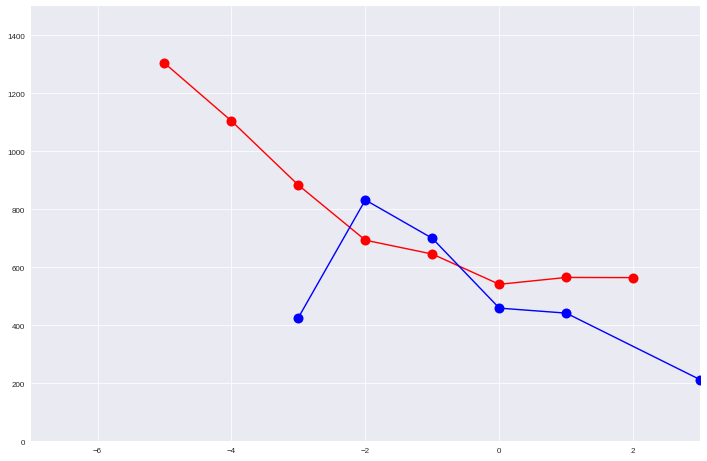

In [13]:
sns.set_style("darkgrid")
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)

ax.plot( predMltGrpsDF["normMLT"], predMltGrpsDF["vSAPS"], "r-" )
ax.plot( predMltGrpsDF["normMLT"], predMltGrpsDF["vSAPS"], "r.", markersize=20 )
ax.plot( mltGrpsDF["normMLT"], mltGrpsDF["vSaps"], "b-" )
ax.plot( mltGrpsDF["normMLT"], mltGrpsDF["vSaps"], "b.", markersize=20 )

ax.set_xlim([-7,3])
ax.set_ylim([0,1500])

fig.savefig("../figs/potCompare.pdf",bbox_inches='tight')

In [7]:
def get_geo_coords(row):
    if row["normMLT"] < 0: 
        currMLT = row["normMLT"] + 24.
    else:
        currMLT = row["normMLT"]
    currMlon = convert_mlt( currMLT, row["date"] , m2a=True )
    glat, glon = convert( row["MLAT"], currMlon , 300, row["date"], a2g=True)
    return str(glat) + "__" + str(glon)

velsDataDF["gcoord"] = velsDataDF.apply( get_geo_coords, axis=1 )
velsDataDF["glat"] = [ float( x.split("__")[0] ) for x in velsDataDF["gcoord"] ]
velsDataDF["glon"] = [ float( x.split("__")[1] ) for x in velsDataDF["gcoord"] ]

In [8]:

def get_efield(row):
    Bx,By,Bz,Bf, yeardec = gridigrf12( row["date"], 0, 1, 300., row["glat"], row["glon"] )
    Vy = row["vSaps"] * numpy.round( numpy.sin(numpy.deg2rad( row["azim"] )), 2 )
    Vx = row["vSaps"] * numpy.round( numpy.cos(numpy.deg2rad( row["azim"] )), 2 )
    Vz = 0.
    Ex = Bz[0] * -1 * Vy * 1e-9 # nT
    Ey = Bz[0] * Vx * 1e-9 # nT
    Ez = Bx[0] * Vy * 1e-9 - By[0] * Vx * 1e-9 # nT
    # Round electric fields by 2
    Ex = numpy.round( Ex * 1e3 , 4 ) # mV/m
    Ey = numpy.round( Ey * 1e3 , 4 ) # mV/m
    Ez = numpy.round( Ez * 1e3 , 4 ) # mV/m
    return str(Ex) + "__" + str(Ey) + "__" + str(Ez)

velsDataDF["Efield"] = velsDataDF.apply( get_efield, axis=1 )
velsDataDF["Ex"] = [ float( x.split("__")[0] ) for x in velsDataDF["Efield"] ]
velsDataDF["Ey"] = [ float( x.split("__")[1] ) for x in velsDataDF["Efield"] ]
velsDataDF["Ez"] = [ float( x.split("__")[2] ) for x in velsDataDF["Efield"] ]
velsDataDF["Efield"] = numpy.sqrt( numpy.square(velsDataDF["Ex"]) +\
                                 numpy.square(velsDataDF["Ey"]) +\
                                 numpy.square(velsDataDF["Ez"]))

In [9]:
mltVelsVarsDF = velsDataDF[ ["normMLT", "MLAT", "vSaps", "Efield"] \
                    ].groupby( ["normMLT", "MLAT"] ).max().reset_index()
mltVelsVarsDF.columns = ["normMLT", "MLAT", "mean_vel", "mean_efld"]
mltVelsVarsDF.head()

,normMLT,MLAT,mean_vel,mean_efld
0,-3.0,62.5,424.75,20.731694
1,-3.0,63.0,426.26,20.852122
2,-2.0,61.5,273.07,13.210209
3,-2.0,62.0,346.19,16.770048
4,-2.0,62.5,387.93,18.863310


In [10]:
# Arrays to store potential
potBinArr = []
potNrmMltArr = []
potMlatArr = []
potPotArr = []

for cmlt in mltVelsVarsDF["normMLT"].unique().tolist():
    # Get Uniq Lats at the MLT!
    selMltDF = mltVelsVarsDF[ mltVelsVarsDF["normMLT"] == cmlt ]
    # At each MLT we assume potential is zero at the lowest
    # latitude!
    prevPot = 0
    for cMlat in sorted( selMltDF["MLAT"].unique().tolist() ):
        selLatsDF = selMltDF[ (selMltDF["MLAT"] == cMlat) ]
        # Remember we have 0.5 deg latitude res
        # so we take delLatDist/2
        potLat = selLatsDF[ selLatsDF["MLAT"] == cMlat ]["mean_efld"] * delLatDist/2. * 1e-3 * 1e-3 # kV
        currPot = prevPot - potLat.values[0]
        prevPot = currPot
        potNrmMltArr.append( cmlt )
        potMlatArr.append( cMlat )
        potPotArr.append( round(currPot,2) )
        
potentialDF = pandas.DataFrame({
            "normMLT" : potNrmMltArr,
            "MLAT" : potMlatArr,
            "potential" : potPotArr
            })
potentialDF

,MLAT,normMLT,potential
0,62.5,-3.0,-1.15
1,63.0,-3.0,-2.31
2,61.5,-2.0,-0.73
3,62.0,-2.0,-1.66
4,62.5,-2.0,-2.71
5,63.0,-2.0,-3.91
6,63.5,-2.0,-5.24
7,64.0,-2.0,-7.21
8,64.5,-2.0,-9.48
9,54.0,-1.0,-0.18


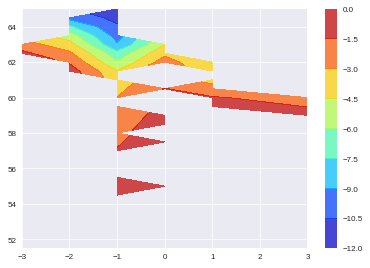

In [11]:
testDF = potentialDF[ ["MLAT", "normMLT", "potential"] ].pivot( "MLAT", "normMLT" )
# testDF = testDF.fillna(0.)
Y = testDF.index.values
X = testDF.columns.levels[1].values
Z=testDF.values
Xi,Yi = numpy.meshgrid(X, Y)
plt.contourf(Xi, Yi, Z, alpha=0.7, cmap=plt.cm.jet);
plt.colorbar()